# Rappi Challenge Data Engineer
**Developer**: COLLANTE, Gerardo

# Librerías

In [2]:
# Data processing libraries
import pandas as pd
import numpy as np
from IPython.display import display
from humanize import intword
# Data plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import missingno as msno
import matplotlib.ticker as mtick
import plotly.express as px
# OS libraries
import os
import requests

# Variables

In [3]:
DEBUG = True
style = 'bmh'
plt.style.use(style)

# Paths

In [4]:
INPUT_DIR = 'input'
OUTPUT_DIR = 'output'
IMG_DIR = 'img'

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(IMG_DIR, exist_ok=True)

In [5]:
def get_imgpath(title:str)->str:
    """
    
    Parameters
    ----------
    title : str
        Title for the img

    Returns
    ---------
    str :
        Absolute path for the img
    """
    return os.path.join(IMG_DIR, title.lower().replace(' ','_') + '.png')

# Carga de datos

In [6]:
# Path of input csv
FILENAME = 'challenge_orders.csv'
PATH = os.path.join(INPUT_DIR, FILENAME) 

# Load DataFrame
df = pd.read_csv(PATH, index_col=0, parse_dates=['CREATED_AT'])

### Guardar archivo

In [7]:
def save_csv(df:pd.DataFrame, filename:str):
    """
    Save CSV
    
    Parameters
    ----------
    df : pd.DataFrame
        Original
        
    filename : str
        Name of file

    Returns
    ---------
    None
    """
    filepath = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(filepath, index=False)

## Comprobación de valores faltantes

<AxesSubplot:>

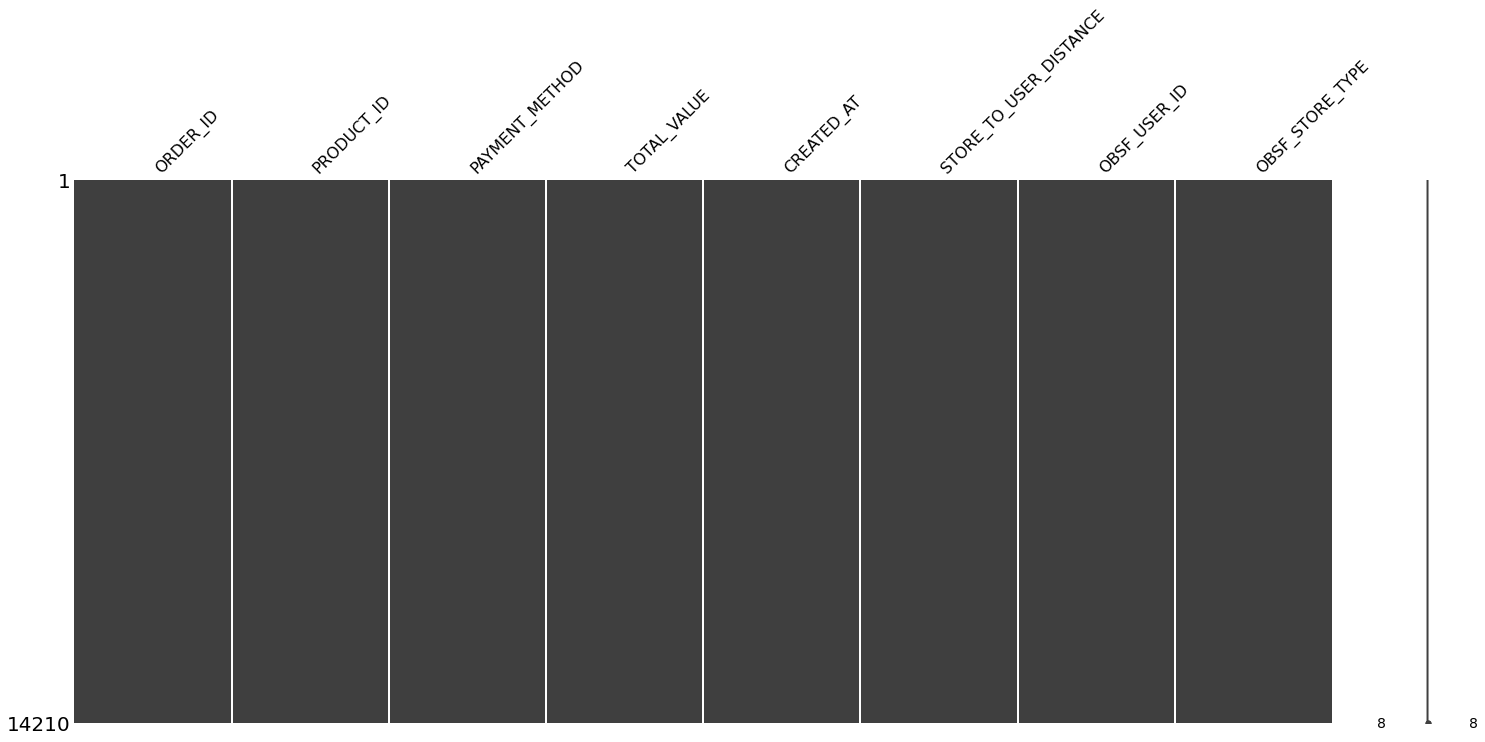

In [8]:
msno.matrix(df)

## Preprocesamiento

In [9]:
df

,ORDER_ID,PRODUCT_ID,PAYMENT_METHOD,TOTAL_VALUE,CREATED_AT,STORE_TO_USER_DISTANCE,OBSF_USER_ID,OBSF_STORE_TYPE
0,35394843,2090144731,cash,1940.0,2019-04-15 13:40:19+00:00,488.0,8540,5
1,35419116,2090144731,cc,8900.0,2019-04-16 20:54:24+00:00,4761.0,3990,14
2,35404241,2090144731,cash,150.0,2019-04-15 21:12:49+00:00,3141.0,19052,5
3,35405366,2090144731,cash,400.0,2019-04-15 21:58:28+00:00,3070.0,16978,14
4,35406544,2090144731,cash,9580.0,2019-04-15 23:36:01+00:00,1210.0,9521,5
...,...,...,...,...,...,...,...,...
14205,35406149,2090145321,cash,0.0,2019-04-15 22:49:57+00:00,5427.0,14444,14
14206,35406452,2090145321,cc,0.0,2019-04-15 23:22:37+00:00,1178.0,7337,5
14207,35406557,2090145321,cc,9350.0,2019-04-15 23:38:10+00:00,1060.0,6508,5
14208,35406605,2090145321,cash,0.0,2019-04-15 23:48:54+00:00,5598.0,2067,14


In [10]:
df.rename(columns={'ORDER_ID':'order', 
                   'PRODUCT_ID':'producto', 
                   'PAYMENT_METHOD':'pay', 
                   'TOTAL_VALUE':'total', 
                   'CREATED_AT':'created', 
                   'STORE_TO_USER_DISTANCE':'dist', 
                   'OBSF_USER_ID':'user', 
                   'OBSF_STORE_TYPE':'store'}, inplace=True)
df.total = df.total.astype(int)
df.dist = df.dist.astype(int)

In [11]:
df.dtypes

order                     int64
producto                  int64
pay                      object
total                     int64
created     datetime64[ns, UTC]
dist                      int64
user                      int64
store                     int64
dtype: object

In [12]:
df.user = df.user.astype(str)
df.store = df.store.astype(str)
df.pay = df.pay.astype(str)
df.order = df.order.astype(str)
df.producto = df.producto.astype(str)

# Necesidades de negocio

In [13]:
APP_ID = 'd2847e56a8474a9fb4416b519b1447ce'
SYMBOL = 'COP'
PRETTY = 'true'
symbol = SYMBOL.lower()

In [14]:
def get_usd_symbol(date:str, symbol:str)->float:
    """
    Function to get USD/COP quote
    
    Parameters
    ----------
    date : str
        Date of the day for get quote
    symbol: str
        Coin to get quote

    Returns
    -------
    float
        Currency USD/[symbol].
    """
    url = f'https://openexchangerates.org/api/historical/{date}.json?app_id={APP_ID} \
            &symbols={symbol}&prettyprint=true'
    try:
        response = requests.get(url, timeout=3)
        response.raise_for_status()
        usd = response.json()['rates'][symbol]
    except requests.exceptions.HTTPError as errh:
        logging.error("Http Error: ",errh)
    except requests.exceptions.ConnectionError as errc:
        logging.error("Error Connecting: ",errc)
    except requests.exceptions.Timeout as errt:
        logging.error("Timeout Error: ",errt)
    except requests.exceptions.RequestException as err:
        logging.error("Other Error: ",err)
    return float(usd)

In [15]:
def create_currency_df(filepath:str, symbol:str, df:pd.DataFrame)->pd.DataFrame():
    """
    Function to get create Currency DataFrame
    
    Parameters
    ----------
    filepath : str
        Path of the CSV that contains past values of currency quote (if exists)
    symbol : str
        Coin to get quote
    df : pd.DataFrame
        Original DataFrame, used for get dates

    Returns
    ---------
    pd.DataFrame
        Currency DataFrame
    """
    df_name = 'Currency DataFrame'
    
    # Get unique dates
    dates = df.created.apply(lambda x: x.strftime('%Y-%m-%d')).unique()
    
    # Create/load DataFrame
    try:
        # Load usd_df if exists
        usd_df = pd.read_csv(filepath, index_col=0)
        print(f"{df_name} loaded from file.")
    except FileNotFoundError:
        print(f"{df_name} does not exist.")
        # Create DataFrames
        usd_df = pd.DataFrame(columns = ["date", "usd"])
        usd_df.set_index('date', inplace=True)
        print(f"{df_name} created.")
    except:
        print(f"Error creating {df_name}")
        
    # Fill DataFrame
    for index, date in enumerate(dates):
        try: 
            usd_df.loc[date,'usd']
        except:
            usd_df.loc[date]=[get_usd_symbol(date, symbol)]
    print(f"{df_name} filled.")
    
    # Save DataFrame
    usd_df.to_csv(filepath)
    print(f"{df_name} saved.")
    return usd_df

In [16]:
CURRENCY_DIR = 'currency'
USD_CURRENCY = f'usd_{symbol}.csv' # For match with columns df later
CURRENCY_PATH = os.path.join(CURRENCY_DIR, USD_CURRENCY)

# Create folders if doesn't exists
os.makedirs(CURRENCY_DIR, exist_ok=True)

usd_df = create_currency_df(CURRENCY_PATH, SYMBOL, df)

Currency DataFrame loaded from file.
Currency DataFrame filled.
Currency DataFrame saved.


In [17]:
usd_df

,usd
date,
2019-04-15,3122.942901
2019-04-16,3144.438907
2019-04-17,3167.129978


In [18]:
def usd_currency(date:str)->float:
    """
    Get USD/SYMBOL
    
    Parameters
    ----------
    date : str
        currency quote day

    Returns
    ---------
    float
        currency quote for the day
    """
    return usd_df.loc[date].usd

def usd_currency_2(value, date):
    """
    Compute VALUE/(USD/SYMBOL)
    
    Parameters
    ----------
    date : str
        Currency quote day

    Returns
    ---------
    float
        Computed value
    """
    return value/usd_df.loc[date].usd

## Método 1
Directamente se divide el valor del producto por la cotización del dólar en el día.

In [19]:
%%time

df['value'] = df.apply(lambda x: usd_currency_2(x['total'], x['created'].strftime('%Y-%m-%d')), axis=1)

CPU times: user 2.05 s, sys: 10 ms, total: 2.06 s
Wall time: 2.06 s


## Método 2
Se calcula la cotización para cada elemento, posteriormente se dividirá el valor del producto por la cotización.

In [20]:
%%time

col_currency = f'usd_{symbol}'
df[col_currency] = df.created.apply(lambda x: usd_currency(x.strftime('%Y-%m-%d')))
df.total = df.total/df.usd_cop
df.drop(col_currency, axis=1, inplace=True)

CPU times: user 1.95 s, sys: 27 µs, total: 1.95 s
Wall time: 1.95 s


In [21]:
df

,order,producto,pay,total,created,dist,user,store,value
0,35394843,2090144731,cash,0.621209,2019-04-15 13:40:19+00:00,488,8540,5,0.621209
1,35419116,2090144731,cc,2.830394,2019-04-16 20:54:24+00:00,4761,3990,14,2.830394
2,35404241,2090144731,cash,0.048032,2019-04-15 21:12:49+00:00,3141,19052,5,0.048032
3,35405366,2090144731,cash,0.128084,2019-04-15 21:58:28+00:00,3070,16978,14,0.128084
4,35406544,2090144731,cash,3.067619,2019-04-15 23:36:01+00:00,1210,9521,5,3.067619
...,...,...,...,...,...,...,...,...,...
14205,35406149,2090145321,cash,0.000000,2019-04-15 22:49:57+00:00,5427,14444,14,0.000000
14206,35406452,2090145321,cc,0.000000,2019-04-15 23:22:37+00:00,1178,7337,5,0.000000
14207,35406557,2090145321,cc,2.993971,2019-04-15 23:38:10+00:00,1060,6508,5,2.993971
14208,35406605,2090145321,cash,0.000000,2019-04-15 23:48:54+00:00,5598,2067,14,0.000000


## Ranking por tipo de tienda que más dólares generó
Se agrupó por ```store```, sumando sus valores y luego ordenandolos de mayor a menor.

In [22]:
def get_revenue_per_store(df:pd.DataFrame)->pd.DataFrame:
    """
    Get revenues
    
    Parameters
    ----------
    df : pd.DataFrame
        Original

    Returns
    ---------
    pd.DataFrame
        Computed
    """
    revenue = df.groupby(by='store').sum().total.sort_values(ascending=False).to_frame() \
    .rename(columns={'total':'revenue'})
    return revenue

In [23]:
revenue = get_revenue_per_store(df)

In [24]:
revenue.head()

,revenue
store,
1,64438.768164
13,6861.660906
9,5845.515493
4,1856.927791
5,1370.054336


## Ploteo

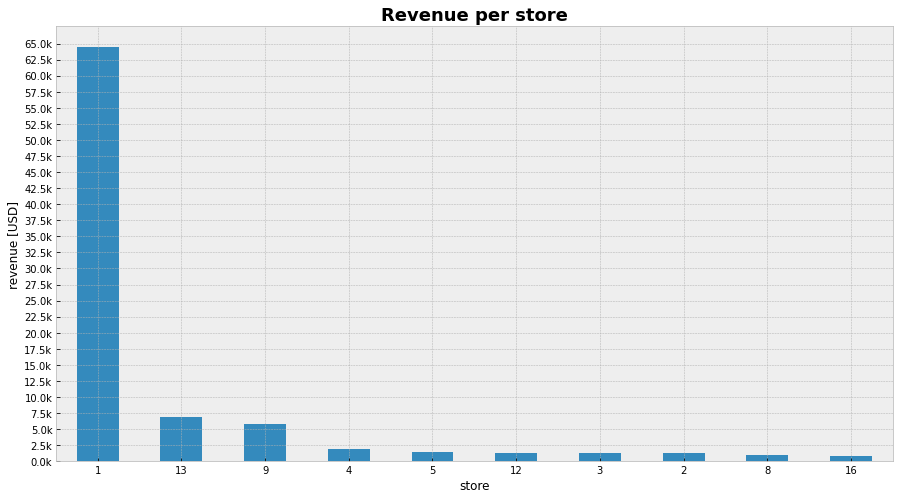

In [69]:
stores_showed = 10
figsize = (15,8)
title = 'Revenue per store'

# Variables
step = 2500
min_ = float(revenue.min())
max_ = float(revenue.max()+step)
human = False

# Draw plot
fig = revenue.nlargest(stores_showed, 'revenue').plot(kind='bar', 
                                                      stacked=True, 
                                                      figsize=figsize)

# Decorations
fig.set_yticks(np.arange(min_, max_, step))
if human:
    y_ticks = [f'{intword(x)}' for x in fig.get_yticks()]
else:
    y_ticks = ['{:,.1f}'.format(x) + 'k' for x in fig.get_yticks()/1000]
fig.set_yticklabels(y_ticks)
fig.set_title(title, fontdict={'size':18, 'weight':'bold'})
fig.set_ylabel('revenue [USD]')
fig.legend().remove()
fig.tick_params(labelrotation=0)
plt.savefig(get_imgpath(title))
plt.show()

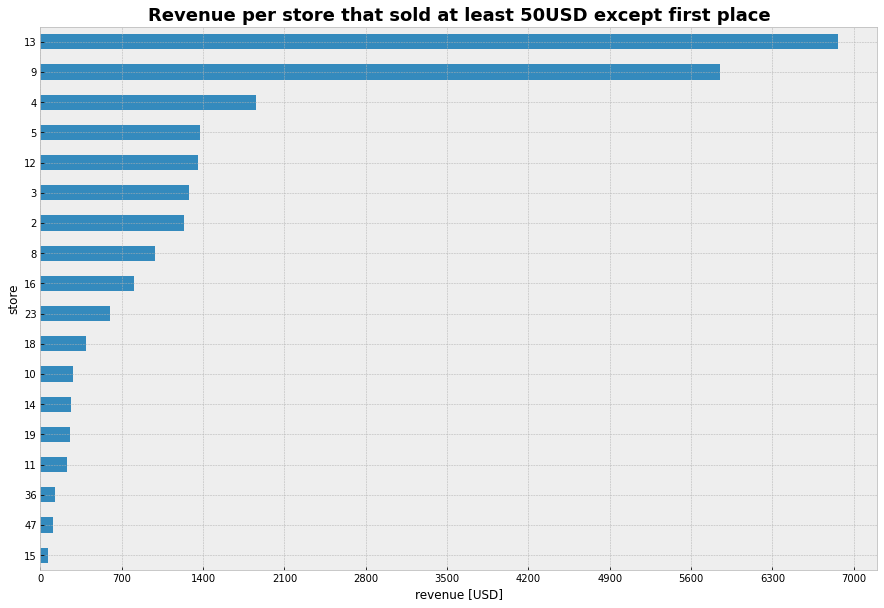

In [65]:
figsize = (15,10)
title = 'Revenue per store that sold at least 50USD except first place'

# Filter df by store that sold at least 50usd, except first place
least = 50
plot_df = revenue[revenue.revenue>least].sort_values(by='revenue', ascending=False).iloc[1:]
bins = 10
min_ = 0
max_ = round(float(plot_df.max()), -3) # Round nearest 1000

# Draw plot
fig = plot_df.sort_values(by='revenue').plot(kind='barh', 
                                             figsize=figsize)
# Decorations
fig.set_xticks(np.linspace(min_, max_, bins+1))
fig.set_xlabel('revenue [USD]')
fig.set_title(title, 
              fontdict={'size':18, 
                        'weight':'bold'})
fig.legend().remove()
plt.savefig(get_imgpath(title))
plt.show()

## Proporción por medio de pago
Primero se filtro por medio de pago, *i.e.* ```pay``` y luego se agrupó por ```store``` calculando la suma total. Este procedimiento se debe realizar dos veces, una por método de pago, pero con la función ```get_revenue_by_pay_method``` es posible obtener este cálculo extendiendolo a $n$ métodos de pago.

In [27]:
df.head()

,order,producto,pay,total,created,dist,user,store,value
0,35394843,2090144731,cash,0.621209,2019-04-15 13:40:19+00:00,488,8540,5,0.621209
1,35419116,2090144731,cc,2.830394,2019-04-16 20:54:24+00:00,4761,3990,14,2.830394
2,35404241,2090144731,cash,0.048032,2019-04-15 21:12:49+00:00,3141,19052,5,0.048032
3,35405366,2090144731,cash,0.128084,2019-04-15 21:58:28+00:00,3070,16978,14,0.128084
4,35406544,2090144731,cash,3.067619,2019-04-15 23:36:01+00:00,1210,9521,5,3.067619


### Método 1

In [28]:
def get_revenue_by_pay_method(df:pd.DataFrame, pay_method:str)->pd.DataFrame:
    """
    Get revenue by payment method
    
    Parameters
    ----------
    df : pd.DataFrame
        Original
    pay_method : str
        Choose between cc or cash

    Returns
    ---------
    pd.DataFrame
        Computed
    """
    # Filter and group-by
    gb = df[df.pay==pay_method].groupby(by='store').sum().total
    
    # Transform to DataFrame
    revenue_per_pay_method = gb.to_frame().rename(columns={'total':f'revenue_{pay_method}'})
    
    # Get final df
    return revenue_per_pay_method

In [29]:
# Get revenue per payment method
revenue_cc = get_revenue_by_pay_method(df,'cc')
revenue_cash = get_revenue_by_pay_method(df,'cash')

In [30]:
# Concat dfs
revenue_per_pay_method = pd.concat([revenue, revenue_cc, revenue_cash], axis=1).fillna(0).astype(int)

In [31]:
# Revenue per df
revenue_per_pay_method['pct_cc'] = revenue_per_pay_method.revenue_cc/revenue_per_pay_method.revenue
revenue_per_pay_method['pct_cash'] = revenue_per_pay_method.revenue_cash/revenue_per_pay_method.revenue
revenue_per_pay_method.fillna(0, inplace=True)

## Ploteo

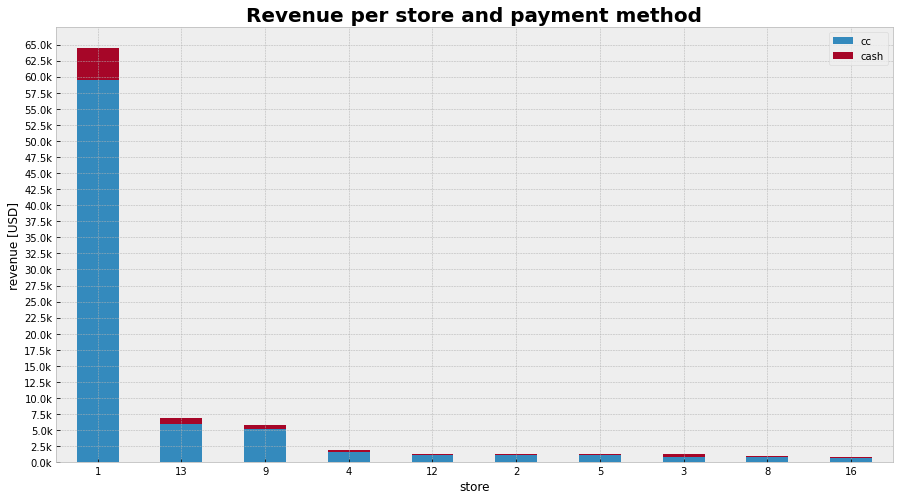

In [66]:
stores_showed = 10
figsize = (15,8)
title = 'Revenue per store and payment method'
imgpath = os.path.join(IMG_DIR, title.lower().replace(' ','_') + '.png')

# Variables
step = 2500
min_ = float(revenue.min())
max_ = float(revenue.max()+step)

# Draw plot
fig = revenue_per_pay_method.loc[:,'revenue_cc':'revenue_cash']. \
nlargest(stores_showed, 'revenue_cc').plot(kind='bar',
                                           stacked=True, 
                                           figsize=figsize)

# Decorations
fig.set_yticks(np.arange(min_, max_, step))
#y_ticks = [f'{intword(x)} USD' for x in list(fig.get_yticks())]
y_ticks = ['{:,.1f}'.format(x) + 'k' for x in fig.get_yticks()/1000]
fig.set_yticklabels(y_ticks)
fig.set_ylabel('revenue [USD]')
fig.set_title(title, fontdict={'size':20, 'weight':'bold'})
fig.legend(['cc','cash'])
fig.tick_params(labelrotation=0)
plt.savefig(get_imgpath(title))
plt.show()

### Método 2

In [33]:
def get_pct_by_pay_method(df:pd.DataFrame, pay_method:str)->pd.DataFrame:
    """
    Get percentage by payment method
    
    Parameters
    ----------
    df : pd.DataFrame
        Original
    pay_method : str
        Choose between cc or cash

    Returns
    ---------
    pd.DataFrame
        Computed
    """
    # Filter and group-by
    revenue_per_store = get_revenue_per_store(df)
    revenue_per_store_filtered = df[df.pay==pay_method].groupby(by='store').sum().total.to_frame() \
    .rename(columns={'total':f'revenue_{pay_method}'})
    
    # Match total and revenue per pay method
    temp_df = pd.concat([revenue_per_store, revenue_per_store_filtered], axis=1).fillna(0)
    
    # Show temporal df
    if DEBUG:
        display(temp_df.head(10))
        
    # Get final df
    pct_by_pay_method = (temp_df[f'revenue_{pay_method}']/temp_df['revenue']).to_frame() \
    .rename(columns={0:f'pct_{pay_method}'})
    return pct_by_pay_method

In [34]:
pct_by_pay_cc = get_pct_by_pay_method(df,'cc')
pct_by_pay_cash = get_pct_by_pay_method(df,'cash')

,revenue,revenue_cc
store,,
1,64438.768164,59460.093634
13,6861.660906,5919.275767
9,5845.515493,5161.676677
4,1856.927791,1588.810256
5,1370.054336,1064.200736
12,1353.521340,1132.894724
3,1277.482395,890.616774
2,1234.247330,1065.342014
8,987.000437,836.005140


,revenue,revenue_cash
store,,
1,64438.768164,4978.674530
13,6861.660906,942.385139
9,5845.515493,683.838816
4,1856.927791,268.117535
5,1370.054336,305.853600
12,1353.521340,220.626616
3,1277.482395,386.865621
2,1234.247330,168.905316
8,987.000437,150.995297


In [35]:
# Create ranking
ranking_df = pd.concat([revenue, pct_by_pay_cc, pct_by_pay_cash], axis=1).fillna(0)

In [36]:
ranking_df.sort_values(by='revenue', ascending=False).head(10)

,revenue,pct_cc,pct_cash
store,,,
1,64438.768164,0.922738,0.077262
13,6861.660906,0.862659,0.137341
9,5845.515493,0.883015,0.116985
4,1856.927791,0.855612,0.144388
5,1370.054336,0.776758,0.223242
12,1353.521340,0.836998,0.163002
3,1277.482395,0.697166,0.302834
2,1234.247330,0.863151,0.136849
8,987.000437,0.847016,0.152984


## Ploteo

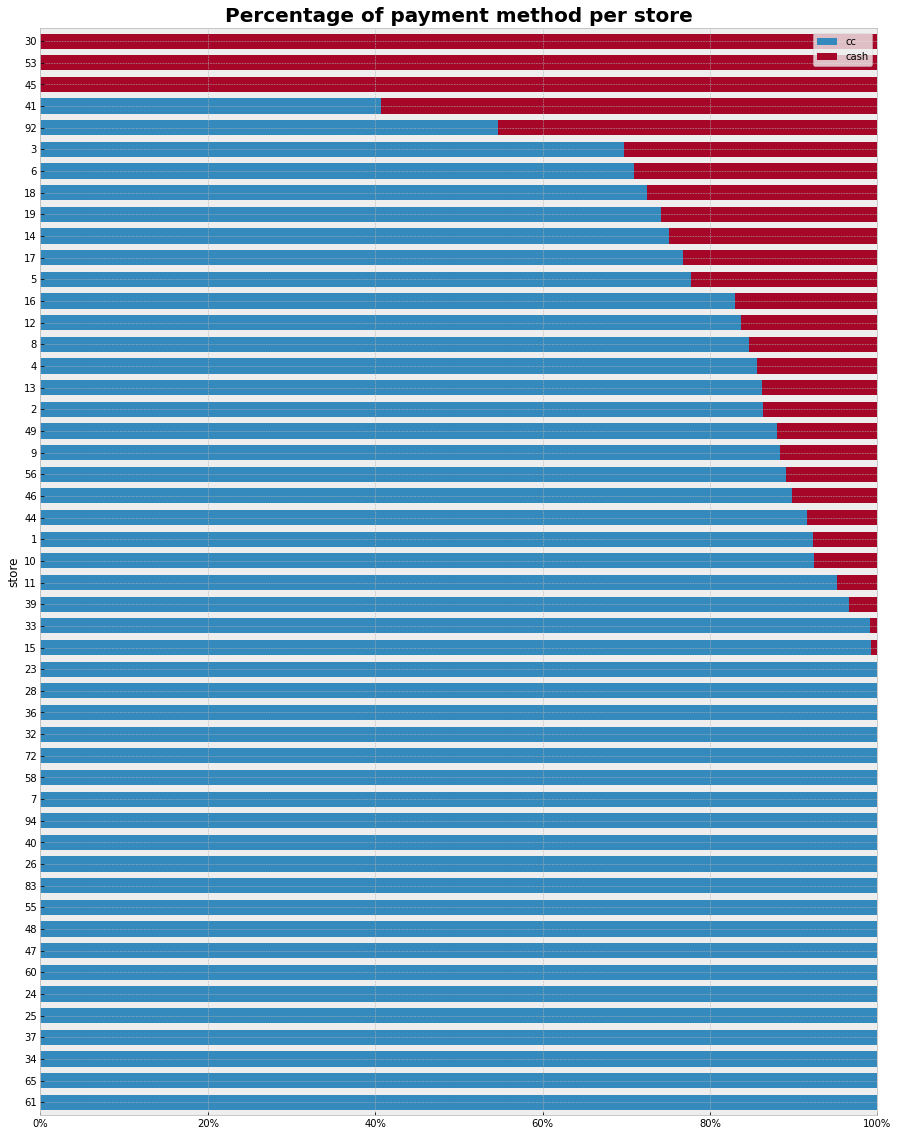

In [62]:
title = 'Percentage of payment method per store'

# Draw plot
plot_df = ranking_df[(ranking_df.pct_cc>0) | (ranking_df.pct_cash>0)]
order_by = 'cash'
fig = plot_df.loc[:,'pct_cc':'pct_cash'].sort_values(by=f'pct_{order_by}').plot(kind='barh',
                                                                                stacked=True,
                                                                                figsize=(15,20), 
                                                                                grid=True, 
                                                                                width=0.7)

# Decorations
fig.set_title(title, fontdict={'size':20, 
                               'weight':'bold'})
fig.legend(['cc','cash'])
fig.tick_params(labelrotation=0)
fig.set_xlim(0,1)
fig.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.savefig(get_imgpath(title))
plt.show()

## AOV
El ```aov``` (valor medio de la orden) se calcula de la siguiente manera:
$$\texttt{AOV} = \frac{\texttt{revenue}}{\texttt{orders}}$$

In [38]:
def get_orders_per_store(df:pd.DataFrame)->pd.DataFrame:
    """
    Get orders per store
    
    Parameters
    ----------
    df : pd.DataFrame
        Original

    Returns
    ---------
    pd.DataFrame
        Computed
    """
    orders = df.groupby(by='store').count().order.rename('orders').to_frame()
    return orders

In [39]:
def get_aov_per_store(df:pd.DataFrame)->pd.DataFrame:
    """
    Compute AOV per store
    
    Parameters
    ----------
    df : pd.DataFrame
        Original

    Returns
    ---------
    pd.DataFrame
        Computed
    """
    # Get orders and revenue
    orders = get_orders_per_store(df)
    revenue = get_revenue_per_store(df)
    
    # Concat to create new DataFrame
    temp_df = pd.concat([orders, revenue], axis=1)
    
    # Compute
    aov = (temp_df.revenue/temp_df.orders).to_frame().rename(columns={0:'aov'})
    return aov

In [40]:
aov = get_aov_per_store(df)

In [41]:
# Add to existing DataFrame
ranking_df = ranking_df.join(aov)

In [42]:
ranking_df.sort_values(by='revenue', ascending=False).head(10)

,revenue,pct_cc,pct_cash,aov
store,,,,
1,64438.768164,0.922738,0.077262,9.939653
13,6861.660906,0.862659,0.137341,5.484941
9,5845.515493,0.883015,0.116985,4.330011
4,1856.927791,0.855612,0.144388,2.852424
5,1370.054336,0.776758,0.223242,1.856442
12,1353.521340,0.836998,0.163002,1.744229
3,1277.482395,0.697166,0.302834,2.718048
2,1234.247330,0.863151,0.136849,3.438015
8,987.000437,0.847016,0.152984,1.258929


In [43]:
save_csv(ranking_df, 'ranking.csv')

In [44]:
# Clear empty values
ranking_df = ranking_df[ranking_df.aov>0]

## Ploteo

In [45]:
# Compute z-score
x = ranking_df.aov
ranking_df['aov_z'] = (x - x.mean())/x.std()
ranking_df['colors'] = ['red' if x < 0 else 'green' for x in ranking_df['aov_z']]
ranking_df.sort_values('aov', inplace=True)

In [46]:
# Set store as index
ranking_df.index = ranking_df.index.astype(str)

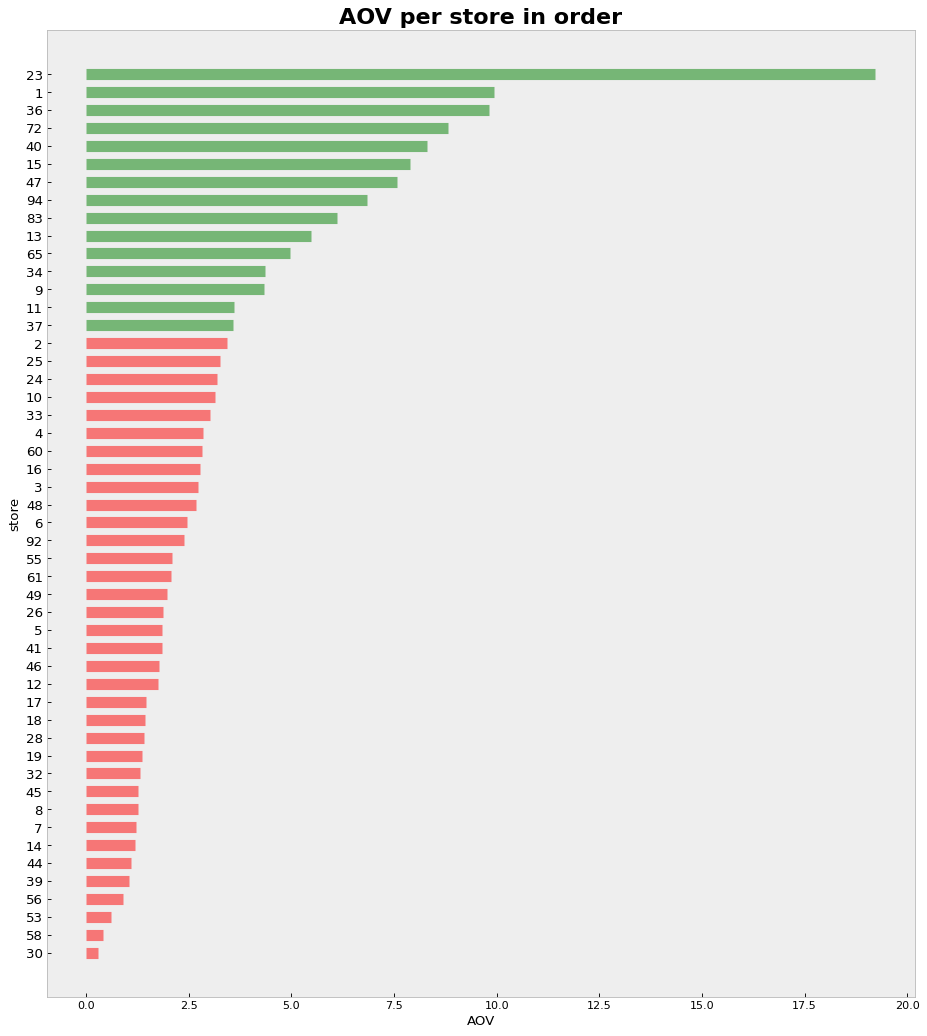

In [67]:
# Draw plot
plt.figure(figsize=(14,16), dpi=80)
plt.hlines(y=ranking_df.index,
           xmin=0,
           xmax=ranking_df.aov,
           color=ranking_df.colors,
           alpha=0.5,
           linewidth=10)

# Decorations
plt.gca().set(ylabel='store', xlabel='AOV')
plt.yticks(ranking_df.index, fontsize=12)
plt.title('AOV per store in order', 
          fontdict={'size':20, 
                    'weight':'bold'})
plt.grid(linestyle='--', alpha=0.5)
plt.savefig(get_imgpath(title))
plt.show()

## Análisis de producto
Se realizará un análisis por producto tomando en cuenta 3 variables:
- **Ganancia total**.
- **Distancia media**.
- **Cantidad de ordenes**.

Consideración:
- ➕ Productos con mayor cantidad de ganancias, ordenes y menor distancia.
- ➖ Productos con menores ganancias, ordenes y mayor distancia en ese orden.

In [48]:
# Create DataFrames
producto_total = df.groupby(by='producto').total.sum().to_frame()
producto_dist = df.groupby(by='producto').dist.mean().to_frame()
producto_orders = df.groupby(by='producto').order.count().to_frame()

# Concat
producto_df = pd.concat([producto_total, producto_dist, producto_orders], axis=1)

# For plotting
producto_df['producto'] = producto_df.index

In [49]:
producto_df

,total,dist,order,producto
producto,,,,
2090039535,5.999149,1249.000000,1,2090039535
2090039543,1.510921,3650.000000,1,2090039543
2090039548,33.694275,5637.500000,4,2090039548
2090039568,5.926781,9076.000000,1,2090039568
2090039570,4.143824,2490.000000,1,2090039570
...,...,...,...,...
6510,0.169188,3679.000000,1,6510
6511,4.277649,4668.500000,2,6511
6512,0.400263,2512.666667,3,6512


## Ploteo

In [70]:
log_x = True
log_y = False
title = 'Orders vs distance per product'

# Draw plot
fig = px.scatter(producto_df, 
                 x="dist",
                 y="order",
                 log_x=log_x,
                 log_y=log_y,
                 size='total',
                 size_max=35,
                 hover_data=['producto']
                )

# Set tile
fig.update_layout(
    title=f'<b>{title}</b>',
    font=dict(
        size=16,
    )
)

# Set axis
fig.update_layout(
    xaxis_title="Distance",
    yaxis_title="Orders",
    font=dict(
        size=14,
    )
)

fig.show()
fig.write_image(get_imgpath(title))

## Serie temporal

In [51]:
ts = df.set_index(df.created)

In [52]:
min_date = ts.index.min()
max_date = ts.index.max()

In [53]:
# Compute df to plot
t = '1H'
ts_orders = ts.resample(t).order.count().to_frame()
ts_total = ts.resample(t).total.sum().to_frame()

In [54]:
display(ts_orders.head(10))
display(ts_total.head(10))

,order
created,
2019-04-15 07:00:00+00:00,3
2019-04-15 08:00:00+00:00,114
2019-04-15 09:00:00+00:00,217
2019-04-15 10:00:00+00:00,282
2019-04-15 11:00:00+00:00,432
2019-04-15 12:00:00+00:00,528
2019-04-15 13:00:00+00:00,380
2019-04-15 14:00:00+00:00,417
2019-04-15 15:00:00+00:00,405


,total
created,
2019-04-15 07:00:00+00:00,0.089339
2019-04-15 08:00:00+00:00,812.798722
2019-04-15 09:00:00+00:00,1017.431026
2019-04-15 10:00:00+00:00,2663.116574
2019-04-15 11:00:00+00:00,3092.065499
2019-04-15 12:00:00+00:00,5296.994381
2019-04-15 13:00:00+00:00,4346.183209
2019-04-15 14:00:00+00:00,2777.377069
2019-04-15 15:00:00+00:00,1062.784401


## Ploteo

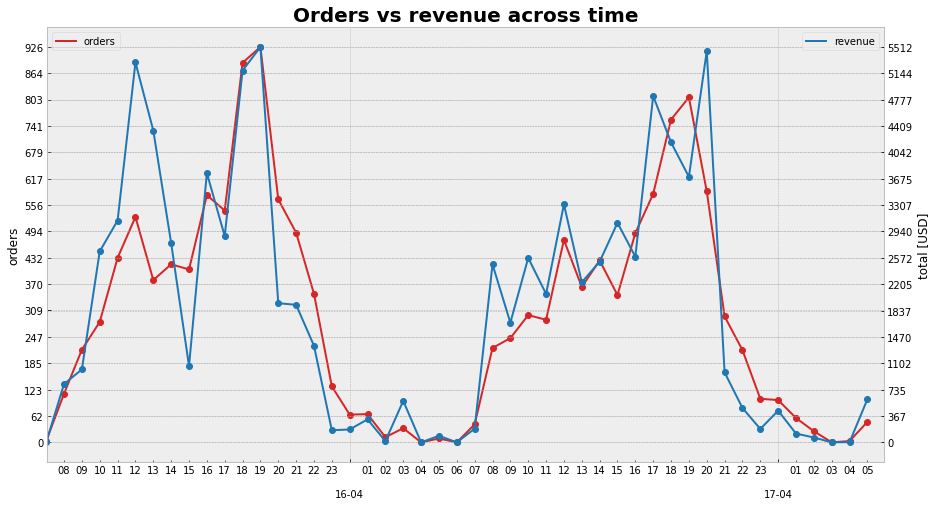

In [68]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

title = 'Orders vs revenue across time'

# Variables
steps = 15
ax1_yticks=np.round(np.linspace(ts_orders.min(), ts_orders.max(), steps+1),0)
ax2_yticks=np.linspace(ts_total.min(), ts_total.max(), steps+1)
ax1_color='tab:red'
ax2_color='tab:blue'

# Draw plot
fig, ax1 = plt.subplots(figsize=(15,8))
ax1.plot(ts_orders, color=ax1_color, label='orders', linewidth=2)
ax1.plot(ts_orders, 'o', color=ax1_color)

# Decorate
#ax1.set_xlabel('date')
ax1.set_ylabel('orders')
ax1.tick_params(axis='y')
ax1.set_yticks(ax1_yticks)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# Draw plot
ax2.plot(ts_total, color=ax2_color, label='revenue')
ax2.plot(ts_total, 'o', color=ax2_color)

# Decorate
ax2.set_ylabel('total')
ax2.set_yticks(ax2_yticks)
ax2_ytickslabels = ["%.1fk" % x for x in (ax2.get_yticks()/1000)]
#ax2_ytickslabels = [str(x) for x in ax2.get_yticks()]
#ax2_ytickslabels = ['{:,.1f}'.format(x) + 'k' for x in ax2_yticks/1000]
#ax2.set_yticklabels(ax2_ytickslabels)
ax2.legend(loc='upper right')
ax2.set_ylabel('total [USD]')
ax2.set_xlim(min_date,max_date)
plt.title('Orders vs revenue across time', 
          fontdict={'size':20, 
                    'weight':'bold'})

# Define the date format
ax1.xaxis.set(
    major_locator=mdates.DayLocator(),
    major_formatter=mdates.DateFormatter("\n\n%d-%m"),
    minor_locator=mdates.HourLocator(interval=1),
    minor_formatter=mdates.DateFormatter("%H"),
)

plt.savefig(get_imgpath(title))
plt.show()